# PyTorch Workflow

**Workflow:**
1. Data (load and clean data)
2. Build model
3. Fit model to the data (training)
4. Evaluate model
5. Save and reload model

In [314]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from pathlib import Path

torch.__version__

'2.0.1'

In [313]:
torch.has_mps

True

## 1. Data

In [ ]:
# creating known parameters and sample linear regression problem

weight = 0.7
bias = 0.3

start = 0
end = 1

step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting Data

In [ ]:
len(X), len(y)

(50, 50)

In [ ]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_test), len(y_test), len(X_train), len(y_train)

(10, 10, 40, 40)

In [ ]:
def plot_predictions(training_data= X_train, train_labels = y_train, test_data=X_test, test_labels=y_test, predictions=None):
    """
    Plots Predictions
    """
    
    plt.figure(figsize=(10,7))
    
    plt.scatter(training_data, train_labels, c="b", s=10, label="Training Data")
    
    plt.scatter(test_data, test_labels, c="g", s=10, label="Testing Data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=10, label="Predictions")
    
    plt.legend(prop={"size": 14});

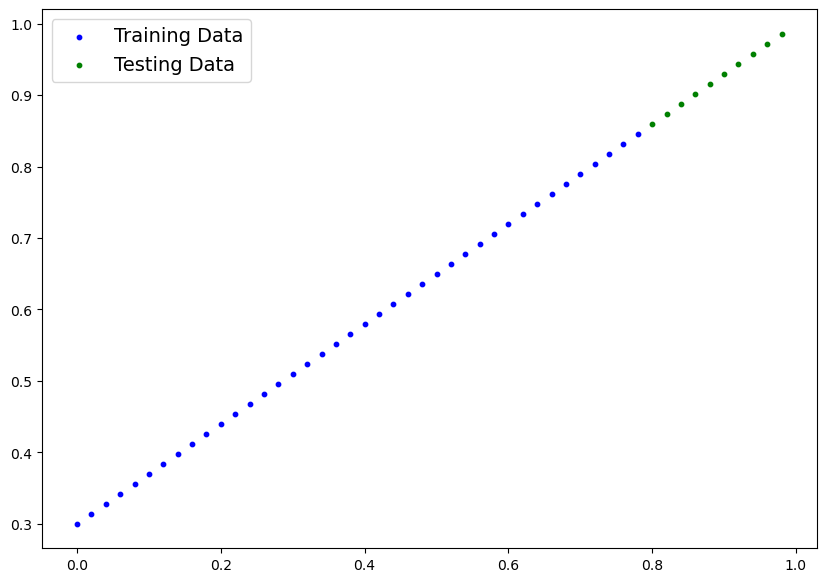

In [ ]:
plot_predictions()

## 2. Build Model

What this model does:
* Starts with random values for weight and bias
* Looks at the training data to adjust the random values to better represent or get closer to the ideal weight and bias values

How does the model do this?
1. Gradient Descent
2. Backpropagation

In [ ]:
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        
        # Initialize model parameters/layers
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
        #requires grad -> gradient descent
        
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
        
        # forward method defines the computation of the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### Model Building Essentials

* `torch.nn` - contains all the building locks for computational graphs 
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - the base class for all neural network modules, when used as a subclass you should always overwrite forward() method
* `torch.optim` - where the optimizers in pytorch live, they help with gradient descent
* `def forward()` - all nn.Module subclass require to overwrite this method, which defines the computation of the model 

In [301]:
# Create random seed
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [302]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making Predictions

In [303]:
with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

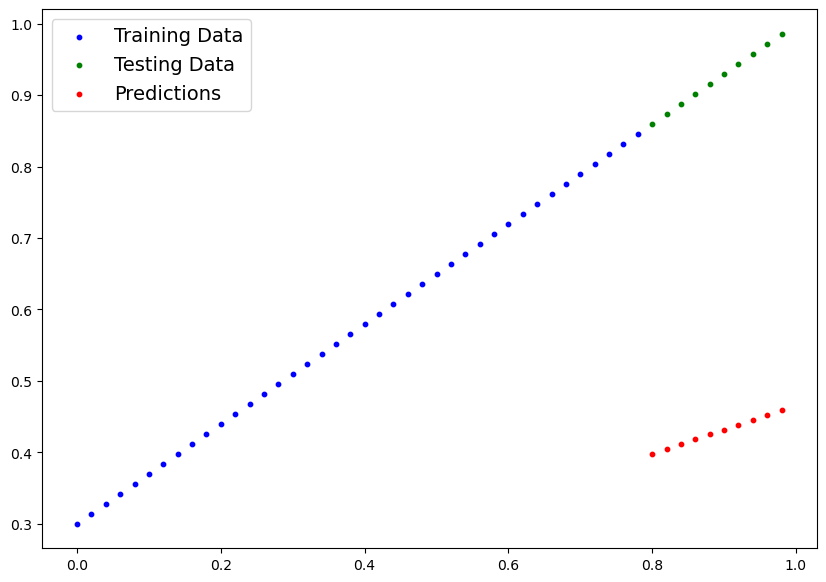

In [304]:
plot_predictions(predictions=y_preds)

## 3. Train Model

In [305]:
# loss function
loss_fn = nn.L1Loss()

# optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.01)

### Training Loop + Testing Loop

0. Loop through data
1. Forward pass/propagation (involves data moving through the `forward()` function or data moving through layers from input to output layer) to make predictions on data
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (backpropagation)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (gradient descent)

In [306]:
torch.manual_seed(42)
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model_0.train()
    
    y_pred = model_0(X_train)
    
    loss = loss_fn(y_pred, y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    ## Testing
    model_0.eval() # turns off different settings that are not used for testing/evaluation
    
    with torch.inference_mode(): # turns off gradient tracking and some other things as well
        # 1. Do the forward pass
        test_pred = model_0(X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
        
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
    

Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
Epoch: 1 | Loss: 0.3013603389263153 | Test Loss: 0.4675942063331604
Epoch: 2 | Loss: 0.28983935713768005 | Test Loss: 0.4541231691837311
Epoch: 3 | Loss: 0.2783183455467224 | Test Loss: 0.44065219163894653
Epoch: 4 | Loss: 0.26679736375808716 | Test Loss: 0.4271811842918396
Epoch: 5 | Loss: 0.2552763521671295 | Test Loss: 0.41371020674705505
Epoch: 6 | Loss: 0.24375534057617188 | Test Loss: 0.40023916959762573
Epoch: 7 | Loss: 0.23223432898521423 | Test Loss: 0.3867681920528412
Epoch: 8 | Loss: 0.22071333229541779 | Test Loss: 0.37329721450805664
Epoch: 9 | Loss: 0.20919232070446014 | Test Loss: 0.3598262071609497
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
Epoch: 11 | Loss: 0.18615034222602844 | Test Loss: 0.3328842222690582
Epoch: 12 | Loss: 0.1746293306350708 | Test Loss: 0.3194132149219513
Epoch: 13 | Loss: 0.16310831904411316 | Test Loss: 0.30594223737716675
Epoch: 14 | Loss: 0.151587337

In [307]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [308]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

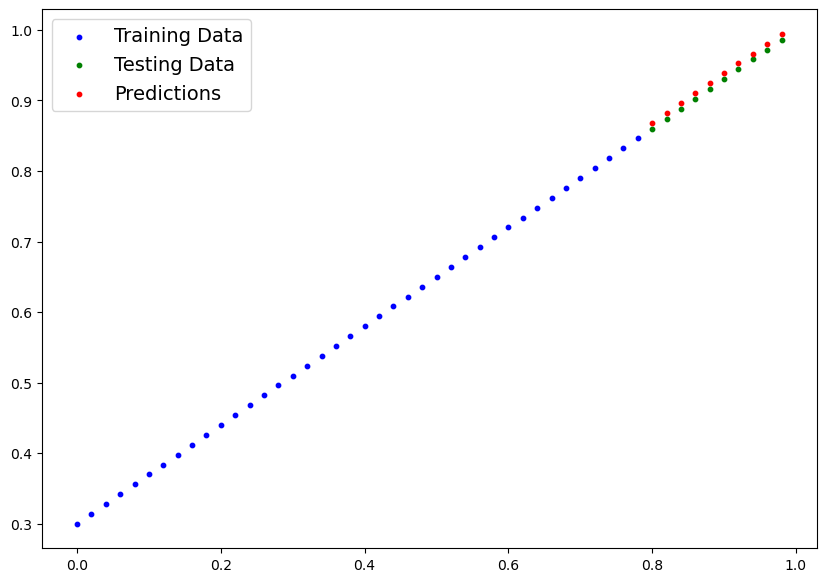

In [309]:
plot_predictions(predictions=y_preds_new)

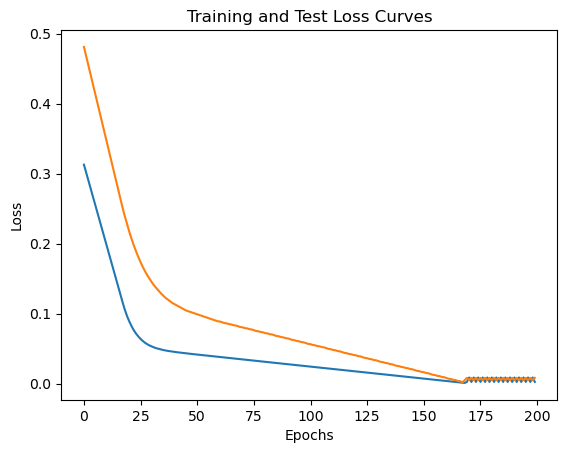

In [310]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show();

## 5. Saving Model

In [311]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [316]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "01_pt_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [320]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [321]:
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [322]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])